# Numerical Exercises 04

## Exercise 04.1

In Statistical Mechanics the Maxwell–Boltzmann distribution (<a href="https://en.wikipedia.org/wiki/Maxwell%E2%80%93Boltzmann_distribution" target="_blank">Link Wikipedia</a>) is a probability distribution used for describing particle speeds in idealized gases. However, rarefied gases at ordinary temperatures behave very nearly like an ideal gas and the Maxwell–Boltzmann speed distribution is an excellent approximation for such gases. For a 3D system its formula is:
$$p(v,T) = \left( \frac{m}{2\pi k_B T} \right)^{3/2} 4\pi v^2 e^{-\frac{m v^2}{2 k_B T}}$$

By using LJ reduced units (Lenght: $\sigma$; Energy: $\epsilon$; Mass: the mass, $m$, of the particles; Temperature: $\epsilon/k_B$; velocity: $\sqrt{\epsilon/m}$) its form becomes:
$$p(v^*,T^*) = \frac{1}{(2\pi T^*)^{3/2}} 4\pi (v^*)^2 e^{-\frac{(v^*)^2}{2 T^*}}$$

The NSL_SIMULATOR code already computes the total (internal) energy per particle, $E/N$, the potential energy per particle, $U/N$, the kinetic energy per particle, $K/N$, the temperature, $T$, and the pressure, $P$.

<span style="color:red">Include the calculation of the Maxwell–Boltzmann distribution, $p(v^*,T^*)$, inside your Molecular Dynamics code by using data blocking to obtain single block averages, progressive average values and progressive uncertainties for $p(v^*,T^*)$.</span>

Remember that, the Maxwell–Boltzmann distribution, $p(v^*,T^*)$, can be approximately computed as a **normalized histogram** on an appropriate interval $\left[ 0, v_{max}\right]$ and chosing the number of bins into which you want to divide this interval.

## Solution

The `NSL_SIMULATOR` program contains the necessary code for the molecular dynamics simulation of a system of interacting particles using the Lennard-Jones potential. Through the `input.dat` file, you can specify the type of simulation to perform and the parameters to use. For this exercise, the Verlet integration algorithm is used to calculate the trajectory of the particles. By expanding $\vec{r}(t\pm \delta t)$ in a Taylor series, the formula for position evolution is obtained:

$$\vec{r}(t+\delta t) = \vec{r}(t) + \vec{v}(t)\delta t + \frac{1}{2}\vec{a}(t)\delta t^2 + O(\delta t^3)$$

It's worth noting that the Verlet algorithm doesn't require calculating the particles' velocities for integration. However, it's still possible to compute it from the incremental ratio $\frac{\vec{r}(t + \delta t) - \vec{r}(t - \delta t)}{2\delta t}$, from which we obtain:

$$\vec{v}(t) = \frac{\vec{r}(t + \delta t) - \vec{r}(t - \delta t)}{2\delta t} + O(\delta t^2)$$


Inside the `main()` function, the system is evolved using the data blocking technique. At each integration step, the `measure()` function calculates the properties of interest specified in the `input.dat` file. At the end of the block iteration, the `averages()` function computes the averages and uncertainties of the properties.

To calculate the Maxwell-Boltzmann distribution, I implemented the following instructions within the `measure()` function:

```cpp
if(_measure_pofv){
    for(int i=0; i<_npart; i++){
      double v = sqrt( _particle(i).getvelocity(0) * _particle(i).getvelocity(0) +
                       _particle(i).getvelocity(1) * _particle(i).getvelocity(1) +
                       _particle(i).getvelocity(2) * _particle(i).getvelocity(2) );
      bin_v = int(v/_bin_size_v); //bin index corresponding to velocity v
      if(bin_v < _n_bins_v) _measurement(_index_pofv + bin_v) += 1.0;
    }
  }
```

A normalized histogram of the velocity distribution is then created, with the number of bins specified in the `input.dat` file.

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import maxwell
from scipy.optimize import curve_fit


warnings.filterwarnings('ignore')
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'serif'

---

After implementing the measure of the povf i tried to run the simulation starting in a "usual" configuration, with a starting maxwellian distribution of velocities. I will now plot the measured pofv and the istant temperature to evaluate if the system reaches the equilibrium

In [2]:
data_pofv = pd.read_csv('NSL_SIMULATOR/OUTPUT/4.1_DATA/pofv_2.00.dat', delim_whitespace=True)
data_temp = pd.read_csv('NSL_SIMULATOR/OUTPUT/temperature_istant_2.00.dat', delim_whitespace=True)

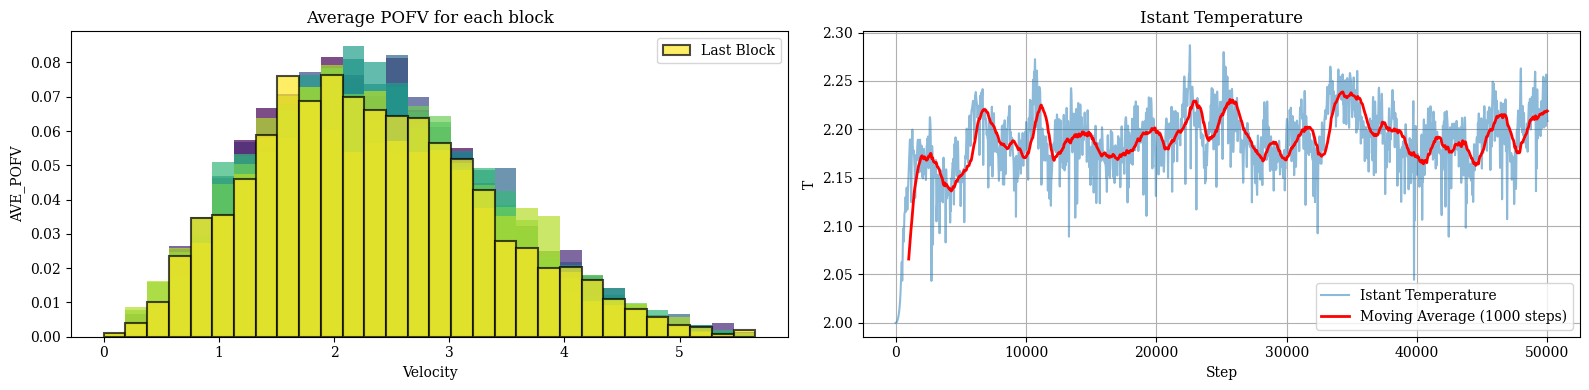

In [3]:
n_bins = 30
width = data_pofv['#VELOCITY:'][1] - data_pofv['#VELOCITY:'][0]
num_blocks = len(data_pofv) // n_bins
colors = cm.viridis(np.linspace(0, 1, num_blocks))

data_temp['Moving_Average'] = data_temp['ACTUAL_T:'].rolling(window=1000).mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

for i in range(num_blocks):
    start_idx = i * n_bins
    end_idx = start_idx + n_bins
    subset = data_pofv.iloc[start_idx:end_idx]
    if i == num_blocks - 1:
        ax1.bar(subset['#VELOCITY:'], subset['AVE_POFV:'], linewidth=1.5, alpha=0.7, color=colors[i], width=width, edgecolor='black', label = "Last Block")
    else:
        ax1.bar(subset['#VELOCITY:'], subset['AVE_POFV:'], linewidth=1.5, alpha=0.7, color=colors[i], width=width,)

ax1.set_title('Average POFV for each block')
ax1.set_xlabel('Velocity')
ax1.set_ylabel('AVE_POFV')
ax1.legend()

ax2.plot(data_temp['#BLOCK:'], data_temp['ACTUAL_T:'], alpha=0.5, label="Istant Temperature")
ax2.plot(data_temp['#BLOCK:'], data_temp['Moving_Average'], color='red', label="Moving Average (1000 steps)", linewidth=2)
ax2.set_xlabel("Step")
ax2.set_ylabel("T")
ax2.set_title("Istant Temperature")
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

We can see from these plots that the system reaches equilibrium after a few steps, as the average POFV stabilizes and the temperature oscillates around a constant value. I will now do a fit of the POFV to the Maxwell-Boltzmann distribution to check if it is consistent with the expected form.

Temperature of the Maxwell-Boltzmann fit: 2.256430297244486


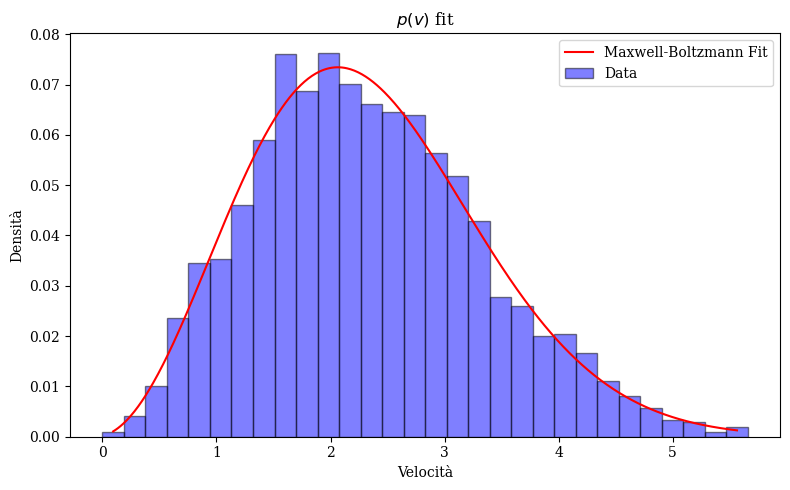

In [4]:
n_bins     = 30
alpha      = 0.05   
sample_n   = 10000   

# last block
num_blocks     = len(data_pofv) // n_bins
last_block_idx = num_blocks - 1
start = last_block_idx * n_bins
end   = start + n_bins
block = data_pofv.iloc[start:end]
velocity = block['#VELOCITY:']
pofv = block['AVE_POFV:']

def maxwell_boltzmann(x, a, loc, scale):
    return a * maxwell.pdf(x, loc=loc, scale=scale)

params, _ = curve_fit(maxwell_boltzmann, velocity, pofv, p0=[1, 0, 1])

a_fit, loc_fit, scale_fit = params
boltzmann_temperature = scale_fit**2
print(f"Temperature of the Maxwell-Boltzmann fit: {boltzmann_temperature}")


fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(velocity, pofv, width=width, alpha=0.5, label='Data', edgecolor='black', color = 'blue')
x_fit = np.linspace(velocity.min(), velocity.max(), 500)
y_fit = maxwell_boltzmann(x_fit, *params)
ax.plot(x_fit, y_fit, color='red', label='Maxwell-Boltzmann Fit')
ax.set_title(r'$p(v)$ fit')
ax.set_xlabel('Velocità')
ax.set_ylabel('Densità')
ax.legend()

plt.tight_layout()
plt.show()

---

## Exercise 4.2

By means of your upgraded code, <span style="color:red">perform MD simulations via a Lennard-Jones model</span> ( e.g. Argon parameters: $\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
- gas phase: $\rho^\star = 0.05$, $T^\star \sim  2.0$ (cut-off radius: $r_c = 5.0$)

starting from a <span style="color:red">**very low entropic** initial configuration</span>:
1. initial **particle positions**: <span style="color:red">fcc crystal occupying half of the simulation box in each dimension</span>
2. initial **velocity distribution**: <span style="color:red">$p_\delta(v^*,T^*) = \delta\left( v^* - v_{T^*}\right)$</span> where $v_{T^*}$ is suitably connected to $T^*$. For example, this condition could be obtained by imposing that every particle has an initial velocity $\pm v_{T^*}$ for **only one** of its velocity components: $v_x$, $v_y$, $v_z$.

The goal is to show that, by evolving such initial condition via a Molecular Dynamics simulation, the velocity distribution tends to approximate the Maxwell–Boltzmann distribution.

- **Produce some pictures that show this convergence**
- The evolution of the system moves towards the increasing of entropy (more homeogeneous configuration of particles)? What would you find by changing the direction of time? Comment on these aspects in your jupyter-notebook

**Note that** the MD simulation will conserve the total energy; thus the kinetic energy and the temperature are not constant of motion ... the comparison should be done with $p(v^*,T^*_{\rm eff})$ where $T^*_{\rm eff}$ is the effective temperature obtained once the system has been equilibrated.

## Solution

To start the system in a low-entropy configuration, I added an `INIT_DELTA` keyword. If this flag is active, the program initializes particle positions according to an FCC configuration that occupies half of the simulation box in each dimension:

```cpp
void System :: read_configuration(){
  /* ... */
  if (_sim_type < 2 and _init_delta == 1){
      cout << "Initializing particles in half of the box with fcc configuration" << endl;
      cinf.open("../INPUT/CONFIG/config.fcc");
      if(cinf.is_open()){
        string comment;
        string particle;
        double x, y, z;
        int ncoord;
        cinf >> ncoord;
        /* ... */
        cinf >> comment;
        for(int i=0; i<_npart; i++){
          cinf >> particle >> x >> y >> z; 
          _particle(i).setposition(0, this->pbc(_halfside(0)*x, 0)); // _halfside(i) is half of the box size
          _particle(i).setposition(1, this->pbc(_halfside(1)*y, 1));
          _particle(i).setposition(2, this->pbc(_halfside(2)*z, 2));
          _particle(i).acceptmove(); // _x_old = _x_new
        }
      } else cerr << "PROBLEM: Unable to open INPUT file config.fcc"<< endl;
  }
  /* ... */
}

```

With the OVITO program, it's possible to visualize the initial configuration of the system.

<div style="text-align: center;">
    <img src="fcc_half.jpg" alt="FCC Half Configuration" style="width: 30%;">
    <p style="font-style: italic;">Initial FCC configuration occupying half of the simulation box.</p>
</div>



To initialize the particles velocities, i modified `void System :: initialize_velocities()` 
```cpp

/* ... */
else if(_init_delta == 1){
    cout << "initializing velocities with delta distribution" << endl;
    // Energy is similar to kT so the velocity is similar to sqrt(kT)
    double fixed_velocity = sqrt(3.0 * _temp); 
    // initialize velocities with a fixed velocity in a random direction
    for (int i = 0; i < _npart; i++) {
      int random_component = int(_rnd.Rannyu(0, 3));
      int direction = int(_rnd.Rannyu(0, 2)) * 2 - 1;
      _particle(i).setvelocity(0, (random_component == 0) ? direction*fixed_velocity : 0.0); 
      _particle(i).setvelocity(1, (random_component == 1) ? direction*fixed_velocity : 0.0); 
      _particle(i).setvelocity(2, (random_component == 2) ? direction*fixed_velocity : 0.0); 
    }
}
/* ... */
```
In this way, each particle has an initial velocity of $v_{T^*}$ in only one random direction.

### Simulation



Starting from a very low-entropy configuration and a delta distribution for velocities, i simulated the system using 20 block with 20000 steps, i have also monitored the istant temperature to evaluate if the system reach a stationary state.

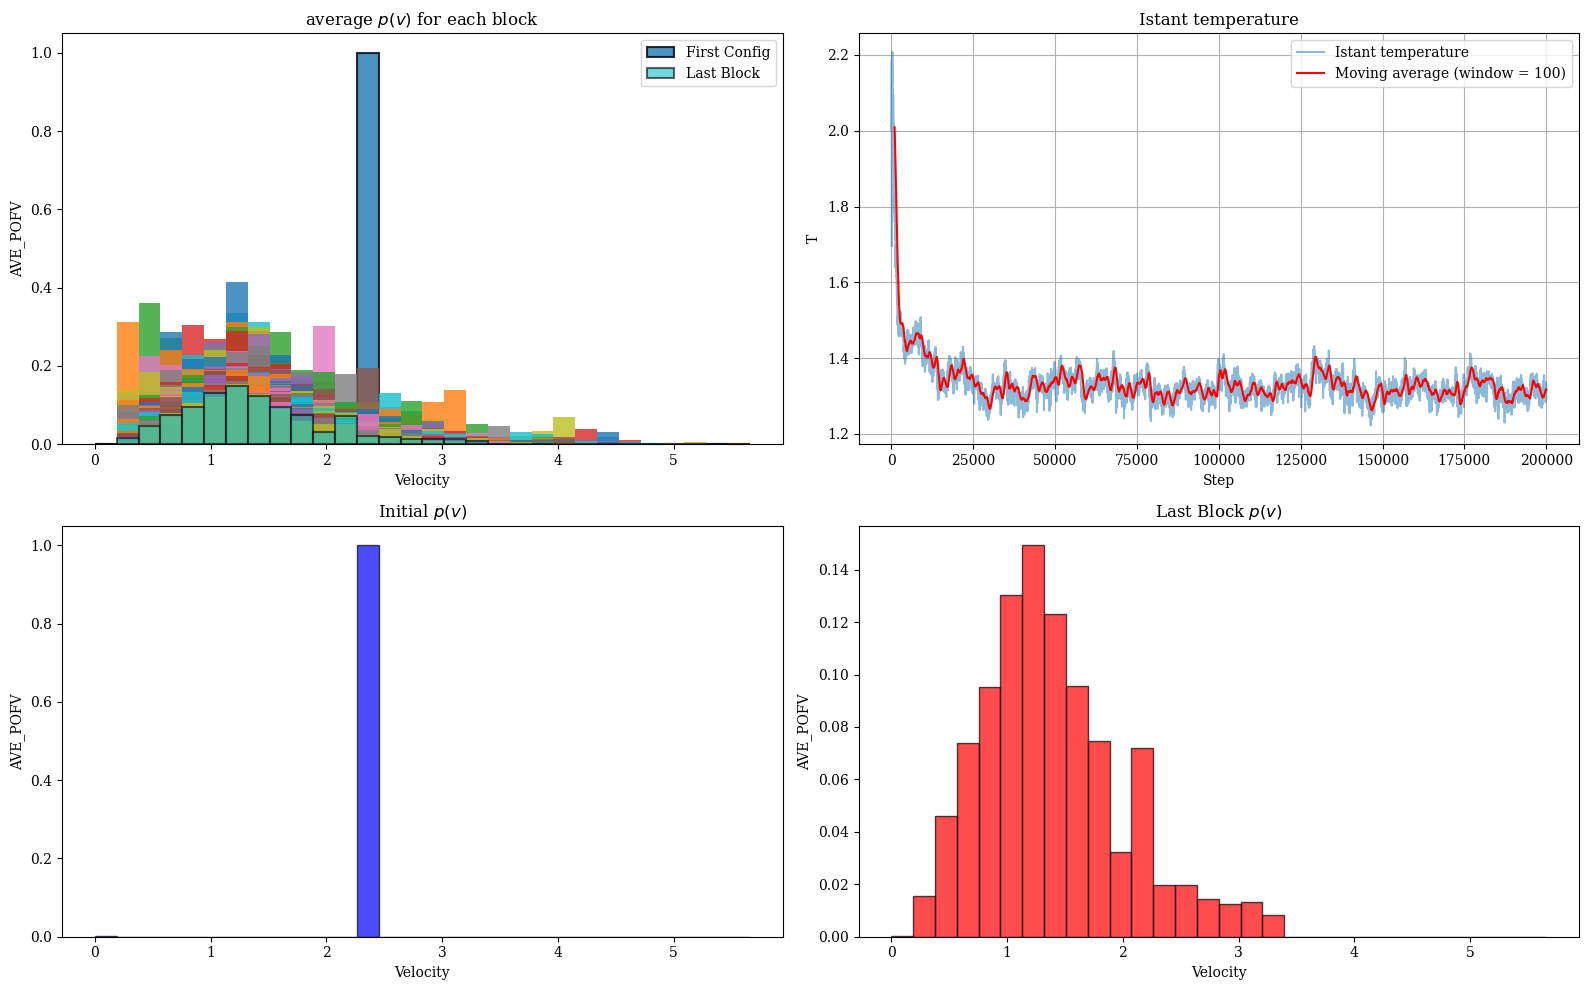

In [ ]:
pofv_delta = pd.read_csv('NSL_SIMULATOR/OUTPUT/4.2_DATA/pofv_2.00.dat', delim_whitespace=True)
n_bins = 30
width = pofv_delta['#VELOCITY:'][1] - pofv_delta['#VELOCITY:'][0]
num_blocks = len(pofv_delta) // n_bins
colors = cm.viridis(np.linspace(0, 1, num_blocks))

data_temp_ist = pd.read_csv('NSL_SIMULATOR/OUTPUT/temperature_delta_ist_2.00.dat', delim_whitespace=True)
data_temp_ist['Moving_Average'] = data_temp_ist['ACTUAL_T:'].rolling(window=1000).mean()

fig, ax = plt.subplots(2, 2, figsize=(16, 10))

# histograms plots
for i in range(0, num_blocks, 1):
    start_idx = i * n_bins
    end_idx = start_idx + n_bins
    subset = pofv_delta.iloc[start_idx:end_idx]
    if i == num_blocks - 1:
        ax[0,0].bar(subset['#VELOCITY:'], subset['AVE_POFV:'], linewidth=1.5, alpha=0.6, width=width, edgecolor='black',label="Last Block")
    elif i == 0:
        ax[0,0].bar(subset['#VELOCITY:'], subset['AVE_POFV:'] * 100, linewidth=1.5, alpha=0.8, width=width, edgecolor='black',label="First Config")
    else:
        ax[0,0].bar(subset['#VELOCITY:'], subset['AVE_POFV:'], linewidth=1.5, alpha=0.8, width=width)

ax[0,0].set_title(r'Average $p(v)$ for each block')
ax[0,0].set_xlabel('Velocity')
ax[0,0].set_ylabel('AVE_POFV')
#ax1.set_ylim([0,0.25])
ax[0,0].legend()

ax[0,1].plot(data_temp_ist['#BLOCK:'], data_temp_ist['ACTUAL_T:'], alpha=0.5, label="Istant temperature")
ax[0,1].plot(data_temp_ist['#BLOCK:'], data_temp_ist['Moving_Average'], color='red', label="Moving average (window = 100)")
ax[0,1].set_xlabel("Step")
ax[0,1].set_ylabel("T")
ax[0,1].set_title("Istant temperature")
ax[0,1].legend()
ax[0,1].grid()

first_block = pofv_delta.iloc[:n_bins]
# multiply bin values for n_step to normalize correctly
ax[1,0].bar(first_block['#VELOCITY:'], first_block['AVE_POFV:']*100, color='blue', width=width, alpha=0.7, edgecolor='black')
ax[1,0].set_title(r'Initial $p(v)$')
ax[1,0].set_xlabel('Velocity')
ax[1,0].set_ylabel('AVE_POFV')


last_block = pofv_delta.iloc[-n_bins:]
ax[1,1].bar(last_block['#VELOCITY:'], last_block['AVE_POFV:'], color='red', width=width, alpha=0.7, edgecolor='black', label="Last Block")
ax[1,1].set_title(r'Last Block $p(v)$')
ax[1,1].set_xlabel('Velocity')
ax[1,1].set_ylabel('AVE_POFV')

plt.tight_layout()
plt.show()

From the plot above, we can observe that, starting from a delta distribution, the system reaches the equilibrium configuration with a Maxwell-Boltzmann velocity distribution. 

## Exercise 4.3

Starting from the final state of an **equilibrated** MD simulation of the system in Exercise 04.2, by changing the direction of time (e.g. by inverting the final velocities, i.e. ... ), try to return back to the very low entropic initial configuration of Exercise 04.2. Is this possible? (for example, one can monitor the behavior of the average **potential energy** and the average **temperature** in **each block** as a function of time going **in both directions**. Show some picture and comment on what you find in your jupyter-notebook.


## Solution

In order to perform a backward evolution i have implemented the following function:

```c++
void System :: reverse_time(){

  for(int i=0; i<_npart; i++){
    double xo = _particle(i).getposition(0,false);
    double xc = _particle(i).getposition(0,true);
    _particle(i).setpositold(0, xc);
    _particle(i).setposition(0, xo);
    xo = _particle(i).getposition(1,false);
    xc = _particle(i).getposition(1,true);
    _particle(i).setpositold(1, xc);
    _particle(i).setposition(1, xo);

    xo = _particle(i).getposition(2,false);
    xc = _particle(i).getposition(2,true);
    _particle(i).setpositold(2, xc);
    _particle(i).setposition(2, xo);
  }

  for(int i=0; i<_npart; i++){
    _particle(i).setvelocity(0, -_particle(i).getvelocity(0));
    _particle(i).setvelocity(1, -_particle(i).getvelocity(1));
    _particle(i).setvelocity(2, -_particle(i).getvelocity(2));
    _particle(i).acceptmove();
  }
  return;
}
```

This function:
- Swaps the actual position with the previous (this because Verlet algorithm uses both coordinates to evaluate the dynamics).

- Inverts all the velocities.

In the `NSL_SIMULATOR` code, I first performed the forward simulation starting from configuration used in Ex 4.2, then called the `reverse_time()` function, and continued the simulation. I simulated the system for 20 blocks with 20000 steps, monitoring the average potential energy and temperature in each block.

In [ ]:
blocks = 20
nsteps = 20000

data_potential_3 = pd.read_csv('NSL_SIMULATOR/OUTPUT/4.3_DATA/potential_energy_2.00.dat', delim_whitespace=True)
data_potential_3.fillna(0, inplace=True)
data_temperature_3 = pd.read_csv('NSL_SIMULATOR/OUTPUT/4.3_DATA/temperature_2.00.dat', delim_whitespace=True)
data_temperature_3.fillna(0, inplace=True)
data_pofv_3 = pd.read_csv('NSL_SIMULATOR/OUTPUT/4.3_DATA/pofv_2.00.dat', delim_whitespace=True)
data_pofv_3.fillna(0, inplace=True)

potential_forward = data_potential_3.iloc[0:blocks]    
potential_forward.fillna(0, inplace=True)
potential_backward = data_potential_3.iloc[blocks:2*blocks]

temperature_forward = data_temperature_3.iloc[0:blocks]
temperature_forward.fillna(0, inplace=True)
temperature_backward = data_temperature_3.iloc[blocks:2*blocks]

combined_blocks = list(range(1, blocks+1)) + list(range(blocks+1, 2*blocks+1))

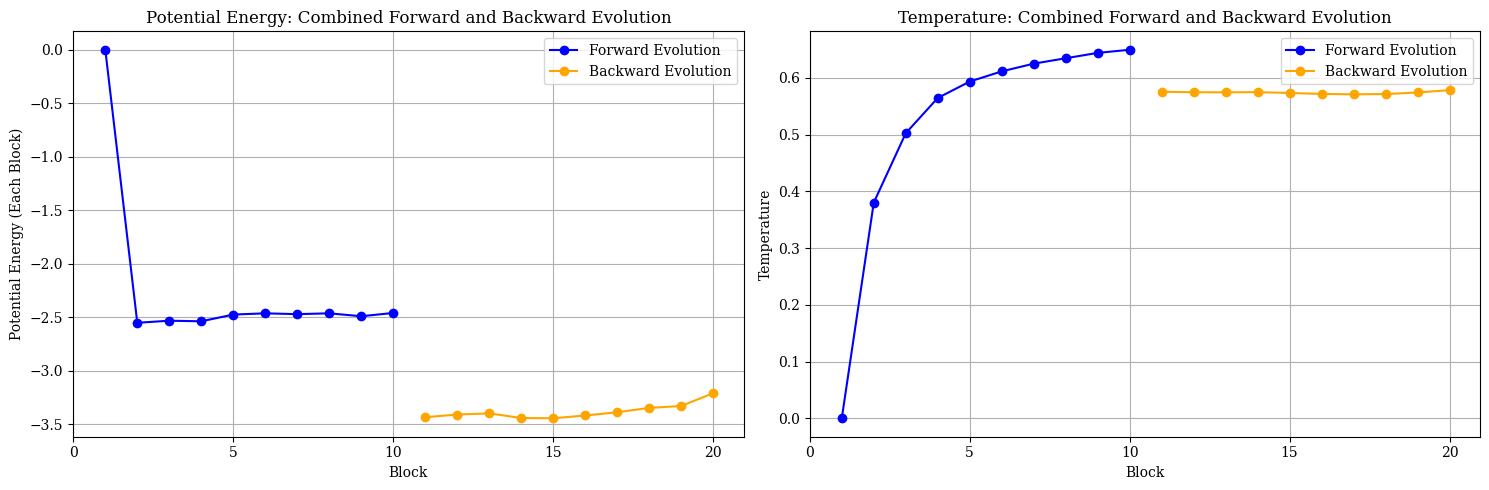

In [11]:
fig, ax = plt.subplots(1,2,figsize=(15, 5))

ax[0].plot(combined_blocks[:blocks], potential_forward['ACTUAL_PE:'], label='Forward Evolution', marker='o', color='blue')
ax[0].plot(combined_blocks[blocks:], potential_backward['ACTUAL_PE:'][::-1], label='Backward Evolution', marker='o', color='orange')

ax[0].set_title('Potential Energy: Combined Forward and Backward Evolution')
ax[0].set_xlabel('Block')
ax[0].set_ylabel('Potential Energy (Each Block)')
ax[0].set_xticks(np.arange(0,2*blocks+1,5))
ax[0].grid()
ax[0].legend()

ax[1].plot(combined_blocks[:blocks], temperature_forward['T_AVE:'], label='Forward Evolution', marker='o', color='blue')
ax[1].plot(combined_blocks[blocks:], temperature_backward['T_AVE:'][::-1], label='Backward Evolution', marker='o', color='orange')

ax[1].set_title('Temperature: Combined Forward and Backward Evolution')
ax[1].set_xlabel('Block')
ax[1].set_ylabel('Temperature')
ax[1].set_xticks(np.arange(0,2*blocks+1,5))
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

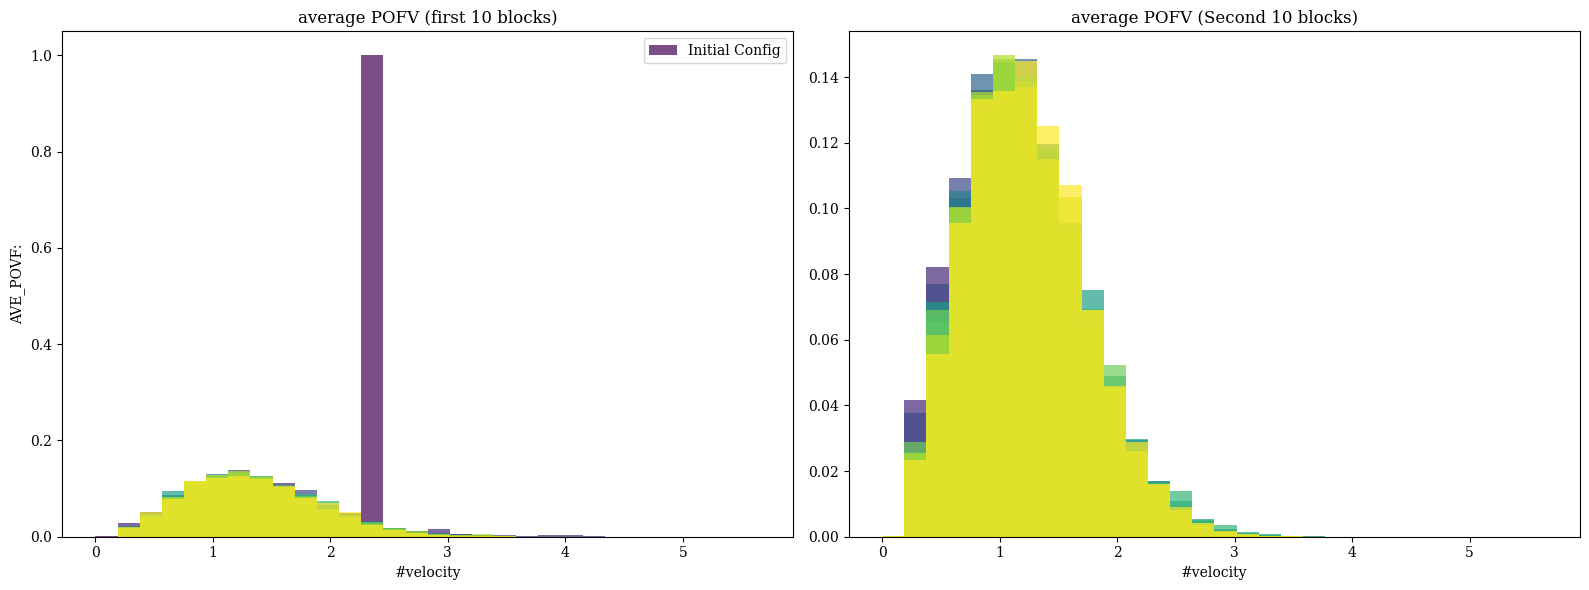

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

colors = cm.viridis(np.linspace(0, 1, blocks))
width = data_pofv_3['#VELOCITY:'][1] - data_pofv_3['#VELOCITY:'][0]

for i in range(0, blocks, 1):
    start_idx = i * 30
    end_idx = start_idx + 30
    subset = data_pofv_3.iloc[start_idx:end_idx]
    if i == 0:
        axes[0].bar(subset['#VELOCITY:'], subset['AVE_POFV:']*20000, alpha=0.7, color=colors[i], label=f'Initial Config', width=width)
    else:
        axes[0].bar(subset['#VELOCITY:'], subset['AVE_POFV:'], alpha=0.7, color=colors[i], width=width)

axes[0].set_title(f'average POFV (first {blocks} blocks)')
axes[0].set_xlabel('#velocity')
axes[0].set_ylabel('AVE_POVF:')
axes[0].legend()

for i in range(blocks + 1 , 2 * blocks):
    start_idx = i * 30
    end_idx = start_idx + 30
    subset = data_pofv_3.iloc[start_idx:end_idx]
    
    axes[1].bar(subset['#VELOCITY:'], subset['AVE_POFV:'], alpha=0.7, color=colors[i - blocks], width=width)

axes[1].set_title(f'average POFV (Second {blocks} blocks)')
axes[1].set_xlabel('#velocity')

plt.tight_layout()
plt.show()

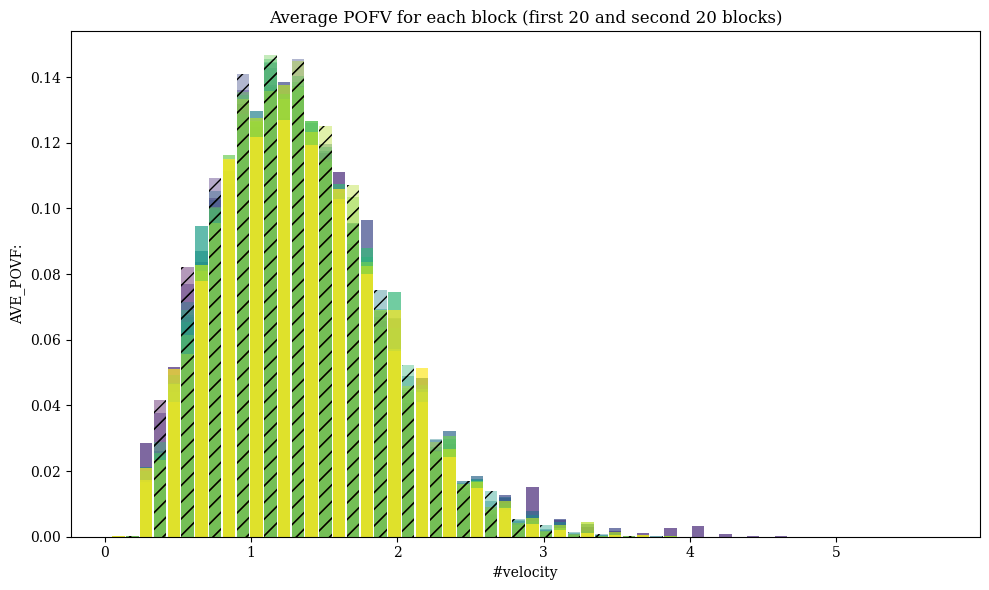

In [9]:
colors = cm.viridis(np.linspace(0, 1, blocks))
width = data_pofv_3['#VELOCITY:'][1] - data_pofv_3['#VELOCITY:'][0]

plt.figure(figsize=(10, 6))

for i in range(0, blocks, 1):
    # first 20 blocks
    start_idx1 = i * 30
    end_idx1 = start_idx1 + 30
    subset1 = data_pofv_3.iloc[start_idx1:end_idx1]
    
    # second 20 blocks
    start_idx2 = (blocks + 1 + i) * 30
    end_idx2 = start_idx2 + 30
    subset2 = data_pofv_3.iloc[start_idx2:end_idx2]
    
    plt.bar(subset1['#VELOCITY:'], subset1['AVE_POFV:'], 
            color=colors[i], width=width*0.45, alpha=0.7, 
            label=f'Block {i+1} (first)')
    
    plt.bar(subset2['#VELOCITY:']+width*0.5, subset2['AVE_POFV:'], 
            color=colors[i], width=width*0.45, alpha=0.4, label=f'Block {i+1} (second)', hatch='//')

plt.title('Average POFV for each block (first 20 and second 20 blocks)')
plt.xlabel('#velocity')
plt.ylabel('AVE_POVF:')
plt.tight_layout()
plt.show()

### Some observations on the results

- Observing these final plots, we can see that the system is not able to return to the initial low-entropy configuration, despite the fact that the Verlet algorithm is perfectly reversible. 

- The $p(v^*,T^*)$ distribution does not return to the delta distribution, but rather evolves towards a Maxwell-Boltzmann distribution and remains in that state.
- The direction of time is not reversible in a thermodynamic sense, as the system tends to evolve towards higher entropy states.